## newnetwork3_cifar10.ipynb
An improved version of network.py, implementing the stochastic gradient descent learning algorithm
for a feedforward neural network. Improvements include the addition of the cross-entropy cost function,
regularization, and better initialization of network weights.

### Libraries

In [1]:
import random
import sys
import numpy as np
import matplotlib.pyplot as plt

### Define the quadratic and cross-entropy cost functions

In [2]:
class QuadraticCost(object):

    @staticmethod
    def fn(a, y):
        # Return the cost associated with an output ``a`` and desired output ``y``.

        return 0.5*np.linalg.norm(a-y)**2

    @staticmethod
    def delta(z, a, y):
        # Return the error delta from the output layer.

        return (a-y) * sigmoid_prime(z)

In [3]:
class CrossEntropyCost(object):

    @staticmethod
    def fn(a, y):
        # Return the cost associated with an output ``a`` and desired output ``y``.
        # Note that np.nan_to_num is used to ensure numerical stability. In particular,
        # if both ``a`` and ``y`` have a 1.0 in the same slot, then the expression (1-y)*np.log(1-a)
        # returns nan.  The np.nan_to_num ensures that that is converted to the correct value (0.0).

       return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

    @staticmethod
    def delta(z, a, y):
        # Return the error delta from the output layer. Note that the parameter ``z`` is not used by the method.
        # It is included in the method's parameters in order to make the interface consistent with the delta method
        # for other cost classes.

        return (a-y)

In [4]:
#### Main Network class
class Network(object):

    def __init__(self, sizes, cost=CrossEntropyCost):
        # The list ``sizes`` contains the number of neurons in the respective layers of the network.
        # For example, if the list was [2, 3, 1] then it would be a three-layer network, with the first layer
        # containing 2 neurons, the second layer 3 neurons, and the third layer 1 neuron. The biases and weights
        # for the network are initialized randomly, using ``self.default_weight_initializer``

        self.num_layers = len(sizes)
        self.sizes = sizes
        self.default_weight_initializer()
        self.cost=cost

    def default_weight_initializer(self):
        # Initialize each weight using a Gaussian distribution with mean 0 and standard deviation 1 over the square root
        # of the number of weights connecting to the same neuron. Initialize the biases using a Gaussian distribution
        # with mean 0 and standard deviation 1.

        # Note that the first layer is assumed to be an input layer, and by convention we won't set any biases for
        # those neurons, since biases are only ever used in computing the outputs from later layers.

        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x) for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def large_weight_initializer(self):
        # Initialize the weights using a Gaussian distribution with mean 0 and standard deviation 1.
        # Initialize the biases using a Gaussian distribution with mean 0 and standard deviation 1.


        # This weight and bias initializer uses the same approach as in Chapter 1, and is included for purposes of comparison.
        # It will usually be better to use the default weight initializer instead.

        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def feedforward(self, a):
        # Return the output of the network if ``a`` is input.

        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            lmbda = 0.0,
            test_data=None,
            monitor_test_cost=False,
            monitor_test_accuracy=False,
            monitor_training_cost=False,
            monitor_training_accuracy=False):

        # Train the neural network using mini-batch stochastic gradient descent. The ``training_data`` is a list of
        # tuples ``(x, y)`` representing the training inputs and the desired outputs. The other non-optional parameters
        # are self-explanatory, as is the regularization parameter ``lmbda``.  The method also accepts ``test_data``,
        # usually either the validation or test data. We can monitor the cost and accuracy on either the test data
        # or the training data, by setting the appropriate flags. The method returns a tuple containing four lists:
        # the (per-epoch) costs on the testn data, the accuracies on the test data,
        # the costs on the training data, and the accuracies on the training data.
        # All values are evaluated at the end of each training epoch. So, for example, if we train for 30 epochs,
        # then the first element of the tuple will be a 30-element list containing the cost on the test data at the end
        # of each epoch. Note that the listsare empty if the corresponding flag is not set.

        if test_data:
            n_data = len(test_data)
        n = len(training_data)
        test_cost, test_accuracy = [], []
        training_cost, training_accuracy = [], []
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(
                    mini_batch, eta, lmbda, len(training_data))
            print("Epoch %s training complete" % j)
            if monitor_training_cost:
                cost = self.total_cost(training_data, lmbda)
                training_cost.append(cost)
                print("Cost on training data: {}".format(cost))
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert=True)
                training_accuracy.append(accuracy)
                print("Accuracy on training data: {} / {}".format(
                    accuracy, n))
            if monitor_test_cost:
                cost = self.total_cost(test_data, lmbda, convert=True)
                test_cost.append(cost)
                print("Cost on test data: {}".format(cost))
            if monitor_test_accuracy:
                accuracy = self.accuracy(test_data)
                test_accuracy.append(accuracy)
                print("Accuracy on test data: {} / {}".format(
                    self.accuracy(test_data), n_data))

        print("\nTraining complete.")
        print("\nConfusion Matrix (Predicted vs. True):")
        confusion_mat = self.evaluate_confusion_matrix(test_data)

        # Define the classes as in draw_image_cifar10
        classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

        # Print header for true classes
        print("         " + "".join(f"{c[:3]:>4}" for c in classes)) # Print first 3 letters of each class
        print("       " + "----" * 10)

        for i, predicted_class_name in enumerate(classes):
            row_str = f"{predicted_class_name[:3]:<7}|" # Print first 3 letters of predicted class
            for j in range(10):
                row_str += f"{confusion_mat[i, j]:>4}"
            print(row_str)


        return test_cost, test_accuracy, training_cost, training_accuracy

    def update_mini_batch(self, mini_batch, eta, lmbda, n):
        # Update the network's weights and biases by applying gradient descent using backpropagation to a single mini batch.
        # The ``mini_batch`` is a list of tuples ``(x, y)``, ``eta`` is the learning rate, ``lmbda`` is the regularization
        # parameter, and ``n`` is the total size of the training data set.

        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        # Return a tuple ``(nabla_b, nabla_w)`` representing the gradient for the cost function C_x.
        # ``nabla_b`` and ``nabla_w`` are layer-by-layer lists of numpy arrays, similar to ``self.biases`` and ``self.weights``.

        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())

        # Note that the variable l in the loop below is used a little differently to the notation in Chapter 2 of the book.
        # Here, l = 1 means the last layer of neurons, l = 2 is the second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact that Python can use negative indices in lists.

        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def accuracy(self, data, convert=False):
        # Return the number of inputs in ``data`` for which the neural network outputs the correct result. The neural network's
        # output is assumed to be the index of whichever neuron in the final layer has the highest activation.

        # The flag ``convert`` should be set to False if the data set is validation or test data (the usual case), and to True
        # if the data set is the training data. The need for this flag arises due to differences in the way the results ``y`` are
        # represented in the different data sets.  In particular, it flags whether we need to convert between the different
        # representations. It may seem strange to use different representations for the different data sets. Why not use the
        # same representation for all three data sets?  It's done for efficiency reasons -- the program usually evaluates the cost
        # on the training data and the accuracy on other data sets. These are different types of computations, and using different
        # representations speeds things up. More details on the representations can be found in mnist_loader.load_data_wrapper.

        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y)) for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y) for (x, y) in data]
        return sum(int(x == y) for (x, y) in results)

    def total_cost(self, data, lmbda, convert=False):
        # Return the total cost for the data set ``data``. The flag ``convert`` should be set to False if the data set is the
        # training data (the usual case), and to True if the data set is the validation or test data.

        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y)/len(data)
        cost += 0.5*(lmbda/len(data))*sum(np.linalg.norm(w)**2 for w in self.weights)
        return cost

    def evaluate_confusion_matrix(self, data):
        """
        Calculates and returns a 10x10 confusion matrix for the given data.
        Rows represent predicted classes, columns represent true classes.
        """
        confusion_matrix = np.zeros((10, 10), dtype=int)
        for x, y in data:
            # Feedforward to get the network's output
            a = self.feedforward(x)
            # Get the predicted class (index of neuron with highest activation)
            predicted_class = np.argmax(a)
            # For test data, y is already an integer representing the true class
            true_class = y
            confusion_matrix[predicted_class, true_class] += 1
        return confusion_matrix

### Miscellaneous functions

In [5]:
def vectorized_result(j):
    # Return a 10-dimensional unit vector with a 1.0 in the j'th position and zeroes elsewhere. This is used to convert
    # a digit (0...9) into a corresponding desired output from the neural network.

    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [6]:
def sigmoid(z):
    # The sigmoid function.

    return 1.0/(1.0+np.exp(-z))

In [7]:
def sigmoid_prime(z):
    # Derivative of the sigmoid function.

    return sigmoid(z)*(1-sigmoid(z))

In [8]:
def draw_image_cifar10(test_set):

    # Specify the image classes
    classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

    images = []
    labels = []
    start_image = 100  # you can change this number to your preferred image location in the test dataset for viewing
    end_image = start_image + 39
    counter = 0
    for image, label in test_set:
      if (start_image <= counter) and (counter <= end_image):
        images.append(image)
        labels.append(label)
      counter += 1

    # Display 40 images
    print('The %2d-th to %2d-th images in the test dataset are shown below:\n' %(start_image, end_image))
    fig = plt.figure(figsize=(25, 8))
    for idx in np.arange(40):
      ax = fig.add_subplot(4, 10, idx+1, xticks=[], yticks=[])
      plt.imshow(images[idx])
      ax.set_title(classes[labels[idx]])
    plt.show()

In [9]:
def load_cifar10():

    import torch
    import torchvision

    training_inputs = []
    training_results = []
    test_inputs = []
    test_results = []

    # load cifar10 training data from torchvision datasets with option "train=True".
    # each cifar10 images has size of 32x32x3 with RGB (red-green-blue) mode, each occupies 32x32 pixels
    training_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
    for image, label in training_set:
      image = np.array(image)/255           # convert image into numpy format, then rescale it from [0,255] to [0,1] range
      image = image.reshape(image.size,1)   # compress 3D RGB format into 1D array format for the neural network input
      training_inputs.append(image)         # store the image
      training_results.append(vectorized_result(label))  # convert label from a digit into a unit vector and store it
    training_data = list(zip(training_inputs, training_results))

    # load cifar10 test data from torchvision datasets with option "train=False".
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
    for image, label in test_set:
      image = np.array(image)/255
      image = image.reshape(image.size,1)
      test_inputs.append(image)
      test_results.append(label)
    test_data = list(zip(test_inputs, test_results))

    draw_image_cifar10(test_set) # you can cooment out this line if you do not want to see some training images

    return (training_data, test_data)

In [10]:
def run_experiments():

    # Run the experiments described in chapter 3 of the book.
    # Increasing the hidden neurons number achieves better recognition accuracy but costs more time
    hidden_neurons = 150
    epochs = 30

    training_data, test_data = load_cifar10()
    net = Network([3072, hidden_neurons, 10], cost = QuadraticCost)
    net.SGD(training_data, epochs, mini_batch_size = 30, eta = 1.0, lmbda = 0.5, test_data = test_data, monitor_test_accuracy = True, \
            monitor_test_cost = True, monitor_training_accuracy = True, monitor_training_cost = True)


It is time to call the function run_experiments() to execute all the commands

100%|██████████| 170M/170M [00:10<00:00, 15.9MB/s]


The 100-th to 139-th images in the test dataset are shown below:



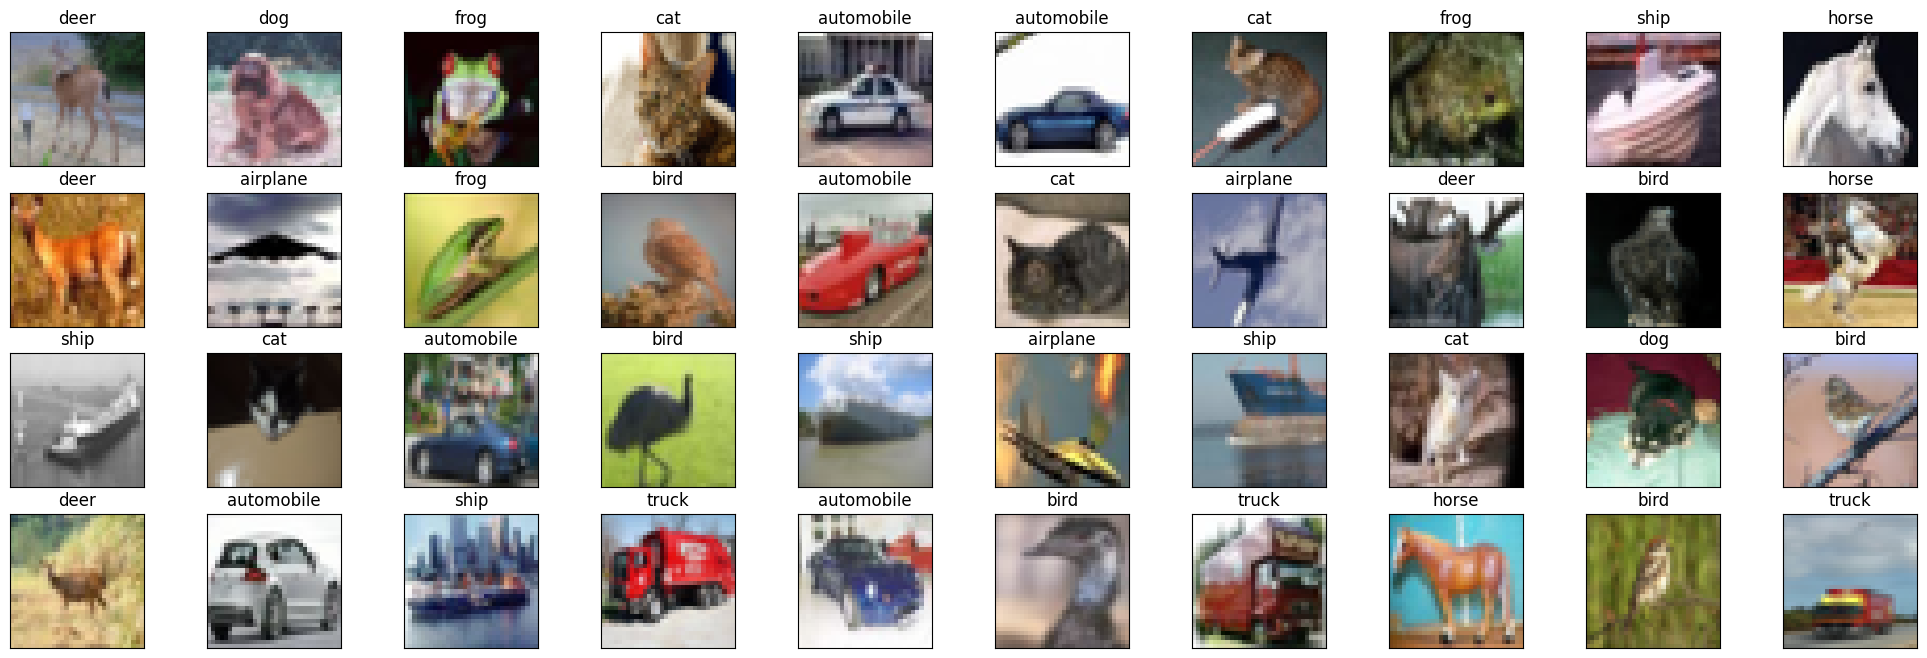

Epoch 0 training complete
Cost on training data: 0.388695383965611
Accuracy on training data: 17788 / 50000
Cost on test data: 0.39308063658981685
Accuracy on test data: 3544 / 10000
Epoch 1 training complete
Cost on training data: 0.3645333766348895
Accuracy on training data: 20748 / 50000
Cost on test data: 0.3720653940746905
Accuracy on test data: 4125 / 10000
Epoch 2 training complete
Cost on training data: 0.3707560782858452
Accuracy on training data: 20206 / 50000
Cost on test data: 0.3814496921033821
Accuracy on test data: 4039 / 10000
Epoch 3 training complete
Cost on training data: 0.3538344794216837
Accuracy on training data: 22417 / 50000
Cost on test data: 0.368613700268727
Accuracy on test data: 4356 / 10000
Epoch 4 training complete
Cost on training data: 0.34790584905003724
Accuracy on training data: 22514 / 50000
Cost on test data: 0.3677366210665468
Accuracy on test data: 4300 / 10000
Epoch 5 training complete
Cost on training data: 0.3501782134830193
Accuracy on train

In [11]:
run_experiments()